In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc  # For garbage collection to free memory
import os
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

tf.keras.backend.clear_session()

# Paths to dataset
image_dir_1 = '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1'
image_dir_2 = '/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2'
metadata_file = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

# Load metadata
labels = pd.read_csv(metadata_file)

# Resize to a smaller size (64x64) to save memory
IMG_SIZE = 64

# Data Generators
def load_and_preprocess_data(labels, image_dir_1, image_dir_2, img_size):
    images = []
    label_list = []

    for _, row in labels.iterrows():
        file_path_1 = os.path.join(image_dir_1, row['image_id'] + '.jpg')
        file_path_2 = os.path.join(image_dir_2, row['image_id'] + '.jpg')

        if os.path.exists(file_path_1):
            img = Image.open(file_path_1).resize((img_size, img_size))  # Resize to img_size x img_size
        elif os.path.exists(file_path_2):
            img = Image.open(file_path_2).resize((img_size, img_size))
        else:
            continue  # Skip if file is missing

        images.append(np.array(img) / 255.0)  # Normalize to [0, 1]
        label_list.append(row['dx'])  # Append diagnosis

    X = np.array(images)  # Shape: (num_samples, img_size, img_size, 3)
    y = pd.factorize(pd.Series(label_list))[0]  # Encode labels as integers
    y_one_hot = to_categorical(y)  # Convert labels to one-hot encoding
    class_names = pd.factorize(pd.Series(label_list))[1]  # Class names for reference
    return X, y_one_hot, class_names

# Call the function to load data
X, y_one_hot, class_names = load_and_preprocess_data(labels, image_dir_1, image_dir_2, IMG_SIZE)

# Check memory usage
print(f"Dataset size (in memory): {X.nbytes / (1024 ** 2):.2f} MB")

# Split into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Free memory
del X, y_one_hot
gc.collect()

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Data augmentation for memory-efficient loading
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()

# Train and validation generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_val, y_val, batch_size=8)

print("Data generators created successfully.")

# Save directory for outputs
save_dir = '/kaggle/working/gan_outputs/'
os.makedirs(save_dir, exist_ok=True)
print(f"All outputs will be saved in: {save_dir}")


Dataset size (in memory): 938.91 MB
Training set shape: (8012, 64, 64, 3)
Validation set shape: (2003, 64, 64, 3)
Data generators created successfully.
All outputs will be saved in: /kaggle/working/gan_outputs/


In [2]:
from tensorflow.keras import mixed_precision

# Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"Mixed precision policy set to: {policy}")


Mixed precision policy set to: <FloatDTypePolicy "mixed_float16">


In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
import gc
import tensorflow as tf
gc.collect()
tf.keras.backend.clear_session()

In [7]:
from tensorflow.keras import layers, models
import tensorflow as tf

latent_dim = 100

# Encoder
encoder = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dense(latent_dim)  # Latent representation
])

# Decoder
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 512),
    layers.Reshape((8, 8, 512)),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(0.2),
    layers.Conv2DTranspose(3, kernel_size=4, padding="same", activation="tanh"),
])

# Full autoencoder model
autoencoder = models.Sequential([
    layers.Input(shape=(64,64,3)),
    encoder,
    decoder
])



In [8]:
import tensorflow as tf

class ThesisGANModel(tf.keras.Model):
    def __init__(self, num_classes=7, dropout_rate=0.4):
        """
        Modified deep learning model for image classification tailored to the HAM10000 dataset.

        Args:
            num_classes (int): Number of output classes.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(ThesisGANModel, self).__init__()

        # Layer Definitions
        self.conv1 = tf.keras.layers.Conv2D(
            128, kernel_size=3, strides=1, padding="same", activation='relu', name="Conv_Layer_1"
        )
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPool_Layer_1")
        self.norm1 = tf.keras.layers.BatchNormalization(name="BatchNorm_Layer_1")

        self.conv2 = tf.keras.layers.Conv2D(
            256, kernel_size=3, strides=1, padding="same", activation='relu', name="Conv_Layer_2"
        )
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPool_Layer_2")
        self.norm2 = tf.keras.layers.BatchNormalization(name="BatchNorm_Layer_2")

        self.conv3 = tf.keras.layers.Conv2D(
            512, kernel_size=3, strides=1, padding="same", activation='relu', name="Conv_Layer_3"
        )
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPool_Layer_3")
        self.norm3 = tf.keras.layers.BatchNormalization(name="BatchNorm_Layer_3")

        self.flatten = tf.keras.layers.Flatten(name="Flatten_Layer")

        self.fc1 = tf.keras.layers.Dense(256, activation='relu', name="Dense_Layer_1")
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate, name="Dropout_Layer_1")
        self.fc2 = tf.keras.layers.Dense(128, activation='relu', name="Dense_Layer_2")
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate, name="Dropout_Layer_2")
        self.fc3 = tf.keras.layers.Dense(num_classes, activation='softmax', name="Output_Layer")

    def call(self, inputs):
        """
        Forward pass of the model.
        """
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.norm1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.norm2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.norm3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Instantiate the model for HAM10000 dataset
model = ThesisGANModel(num_classes=7, dropout_rate=0.4)

# Initialize model by passing a dummy input
dummy_input = tf.random.normal([1, 64, 64, 3])
_ = model(dummy_input)

# Save the model summary to a file
with open("modified_thesis_model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

# Print the model summary to console
model.summary()



Model: "thesis_gan_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_Layer_1 (Conv2D)           │ ?                      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Layer_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Layer_1               │ ?                      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer_2 (Conv2D)           │ ?                      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Layer_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Layer_2               │ ?                      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer_3 (Conv2D)           │ ?                      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_Layer_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_Layer_3               │ ?                      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ ?                      │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ ?                      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ ?                      │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,905,159 (37.79 MB)

 Trainable params: 9,903,367 (37.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
# Generator is just the decoder part (it takes latent vector as input)
def build_generator(latent_dim):
    return decoder

# Discriminator
def build_discriminator(img_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=img_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Compile GAN
def compile_gan(generator, discriminator, latent_dim):
    # Compile the discriminator independently
    discriminator.trainable = True
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

    # Freeze the discriminator when training the GAN
    discriminator.trainable = False

    # Create GAN model
    gan_input = layers.Input(shape=(latent_dim,))  # Latent vector input
    fake_img = generator(gan_input)  # Generator takes latent vector and produces image
    gan_output = discriminator(fake_img)  # Discriminator evaluates the generated image
    gan = models.Model(gan_input, gan_output)

    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5), loss='binary_crossentropy')

    return generator, discriminator, gan

# Build and compile
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))
generator, discriminator, gan = compile_gan(generator, discriminator, latent_dim)

# Output the shapes of the models
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()

Generator Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,065,603 (23.14 MB)

 Trainable params: 6,065,603 (23.14 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,240,321 (50.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,240,321 (50.51 MB)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Compile Discriminator (binary crossentropy loss and Adam optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5), metrics=['accuracy'])

# Compile GAN model (combined model) with the discriminator frozen
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5))


In [15]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the optimizer for the discriminator
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

# Define the discriminator model (with output shape (batch_size, 7) for multi-class classification)
discriminator = tf.keras.Sequential([
    # First Conv2D layer with proper input_shape specified
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),  # This reduces the spatial dimensions
    layers.Dense(7, activation='softmax')  # 7 classes (use softmax for multi-class classification)
])

# Compile the discriminator model
discriminator.compile(optimizer=opt_disc, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import tensorflow as tf
import numpy as np
import time
import os
from tqdm import tqdm

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Loss functions
loss_fn_auto = tf.keras.losses.MeanSquaredError()
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy()

# Optimizers
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

# Compile the autoencoder model
autoencoder.compile(optimizer=opt_autoencoder, loss=loss_fn_auto)

# Compile the discriminator model
discriminator.compile(optimizer=opt_disc, loss=loss_fn_disc, metrics=['accuracy'])

# Metrics storage
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop
for epoch in range(10):  # Adjust the range as needed
    start_time = time.time()
    
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    print(f"\nEpoch {epoch + 1} Training:")
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_generator)):
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass through encoder-decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Forward pass through discriminator
            fake = tf.clip_by_value(generated_image, 0, 1)  # Normalize generated images
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())

        # Save generated image for visualization
        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch + 1}_batch_{idx}.png")

    print(f"\nEpoch {epoch + 1} Validation:")
    for val_batch_real, val_batch_label in val_generator:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch averages
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch metrics
    print(f"Epoch {epoch + 1}, Autoencoder Loss: {avg_autoencoder_loss:.6f}, "
          f"Discriminator Loss: {avg_discriminator_loss:.6f}, Discriminator Accuracy: {avg_discriminator_acc:.6f}")
    print(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss:.6f}, "
          f"Discriminator Loss: {avg_val_discriminator_loss:.6f}, Discriminator Accuracy: {avg_val_discriminator_acc:.6f}")
    print(f"Epoch {epoch + 1} took {time.time() - start_time:.2f} seconds")

# Plotting
import matplotlib.pyplot as plt

# Autoencoder Loss
plt.figure(figsize=(12, 6))
plt.plot(autoencoder_losses_epoch, label='Training Autoencoder Loss')
plt.plot(val_autoencoder_losses_epoch, label='Validation Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Loss')
plt.legend()
plt.savefig(f"{save_dir}/autoencoder_loss.png")
plt.show()

# Discriminator Loss
plt.figure(figsize=(12, 6))
plt.plot(discriminator_losses_epoch, label='Training Discriminator Loss')
plt.plot(val_discriminator_losses_epoch, label='Validation Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.savefig(f"{save_dir}/discriminator_loss.png")
plt.show()

# Discriminator Accuracy
plt.figure(figsize=(12, 6))
plt.plot(discriminator_acc_epoch, label='Training Discriminator Accuracy')
plt.plot(val_discriminator_acc_epoch, label='Validation Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()
plt.savefig(f"{save_dir}/discriminator_accuracy.png")
plt.show()



Epoch 1 Training:


5040it [1:35:09,  1.07s/it]                        

In [ ]:
import tensorflow as tf
import numpy as np
import time
from tqdm import tqdm

# Loss functions
loss_fn_auto = tf.keras.losses.MeanSquaredError()
loss_fn_disc = tf.keras.losses.CategoricalCrossentropy()

# Optimizers
opt_autoencoder = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
opt_disc = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

# Compile the autoencoder model
autoencoder.compile(optimizer=opt_autoencoder, loss=loss_fn_auto)

# Compile the discriminator model
discriminator.compile(optimizer=opt_disc, loss=loss_fn_disc, metrics=['accuracy'])

# Metrics storage
autoencoder_losses_epoch = []
discriminator_losses_epoch = []
discriminator_acc_epoch = []
val_autoencoder_losses_epoch = []
val_discriminator_losses_epoch = []
val_discriminator_acc_epoch = []

# Training loop
for epoch in range(10):
    start_time = time.time()
    
    # Initialize epoch-wise metrics
    epoch_autoencoder_losses = []
    epoch_discriminator_losses = []
    epoch_discriminator_acc = []
    epoch_val_autoencoder_losses = []
    epoch_val_discriminator_losses = []
    epoch_val_discriminator_acc = []

    # Training loop (using train_generator)
    for idx, (batch_real, batch_label) in enumerate(tqdm(train_generator)):
        with tf.GradientTape(persistent=True) as tape:
            # Forward pass through encoder-decoder (autoencoder)
            latent_representation = encoder(batch_real)
            generated_image = decoder(latent_representation)
            loss_autoencoder = loss_fn_auto(batch_real, generated_image)

            # Forward pass through discriminator (output is (batch_size, 7))
            fake = generated_image
            loss_disc_real = loss_fn_disc(batch_label, discriminator(batch_real))  # batch_label is (batch_size, 7)
            loss_disc_fake = loss_fn_disc(batch_label, discriminator(fake))  # batch_label is (batch_size, 7)
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Apply gradients for autoencoder and discriminator
        grads_autoencoder = tape.gradient(loss_autoencoder, autoencoder.trainable_weights)
        opt_autoencoder.apply_gradients(zip(grads_autoencoder, autoencoder.trainable_weights))

        grads_discriminator = tape.gradient(loss_disc, discriminator.trainable_weights)
        opt_disc.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

        # Store batch-wise metrics
        epoch_autoencoder_losses.append(loss_autoencoder.numpy())
        epoch_discriminator_losses.append(loss_disc.numpy())
        epoch_discriminator_acc.append(tf.reduce_mean(tf.keras.metrics.categorical_accuracy(batch_label, discriminator(fake))).numpy())

        # Save generated image for visualization
        if idx % 200 == 0:
            img = tf.keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"{save_dir}/generated_img_epoch_{epoch}_batch_{idx}.png")

    # Validation loop (using val_generator)
    for val_batch_real, val_batch_label in val_generator:
        val_latent_representation = encoder(val_batch_real)
        val_generated_image = decoder(val_latent_representation)
        val_loss_autoencoder = loss_fn_auto(val_batch_real, val_generated_image)
        val_loss_disc_real = loss_fn_disc(val_batch_label, discriminator(val_batch_real))
        val_loss_disc_fake = loss_fn_disc(val_batch_label, discriminator(val_generated_image))
        val_loss_disc = (val_loss_disc_real + val_loss_disc_fake) / 2

        # Calculate accuracy
        val_discriminator_accuracy = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(val_batch_label, discriminator(val_generated_image)))

        # Store validation metrics
        epoch_val_autoencoder_losses.append(val_loss_autoencoder.numpy())
        epoch_val_discriminator_losses.append(val_loss_disc.numpy())
        epoch_val_discriminator_acc.append(val_discriminator_accuracy.numpy())

    # Calculate epoch-wise averages and append to the lists
    avg_autoencoder_loss = np.mean(epoch_autoencoder_losses)
    avg_discriminator_loss = np.mean(epoch_discriminator_losses)
    avg_discriminator_acc = np.mean(epoch_discriminator_acc)
    avg_val_autoencoder_loss = np.mean(epoch_val_autoencoder_losses)
    avg_val_discriminator_loss = np.mean(epoch_val_discriminator_losses)
    avg_val_discriminator_acc = np.mean(epoch_val_discriminator_acc)

    autoencoder_losses_epoch.append(avg_autoencoder_loss)
    discriminator_losses_epoch.append(avg_discriminator_loss)
    discriminator_acc_epoch.append(avg_discriminator_acc)
    val_autoencoder_losses_epoch.append(avg_val_autoencoder_loss)
    val_discriminator_losses_epoch.append(avg_val_discriminator_loss)
    val_discriminator_acc_epoch.append(avg_val_discriminator_acc)

    # Print epoch-wise metrics using tqdm.write
    tqdm.write(f"Epoch {epoch}, Autoencoder Loss: {avg_autoencoder_loss}, Discriminator Loss: {avg_discriminator_loss}, Discriminator Accuracy: {avg_discriminator_acc}")
    tqdm.write(f"Validation - Autoencoder Loss: {avg_val_autoencoder_loss}, Discriminator Loss: {avg_val_discriminator_loss}, Discriminator Accuracy: {avg_val_discriminator_acc}")
    tqdm.write(f"Epoch {epoch} took {time.time() - start_time:.2f} seconds")


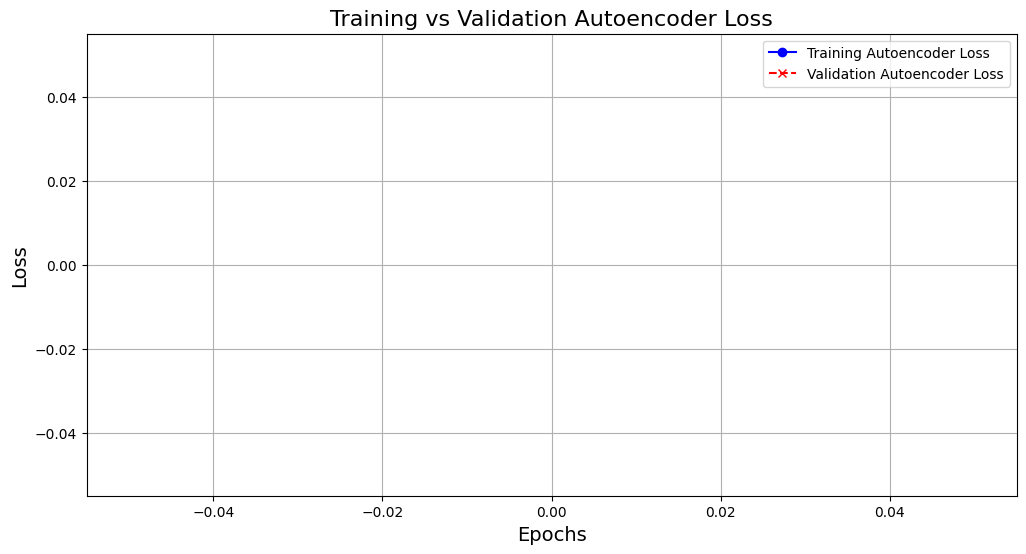

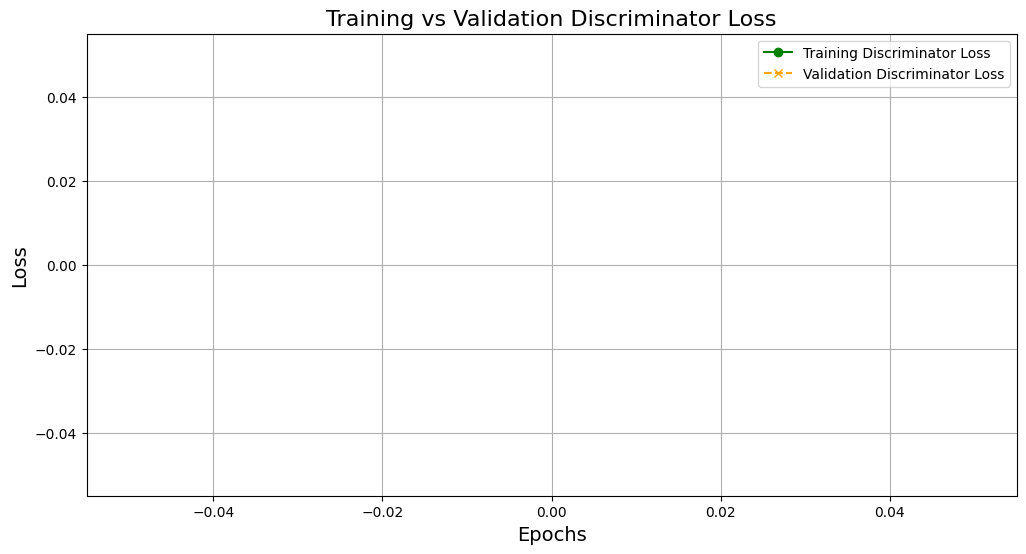

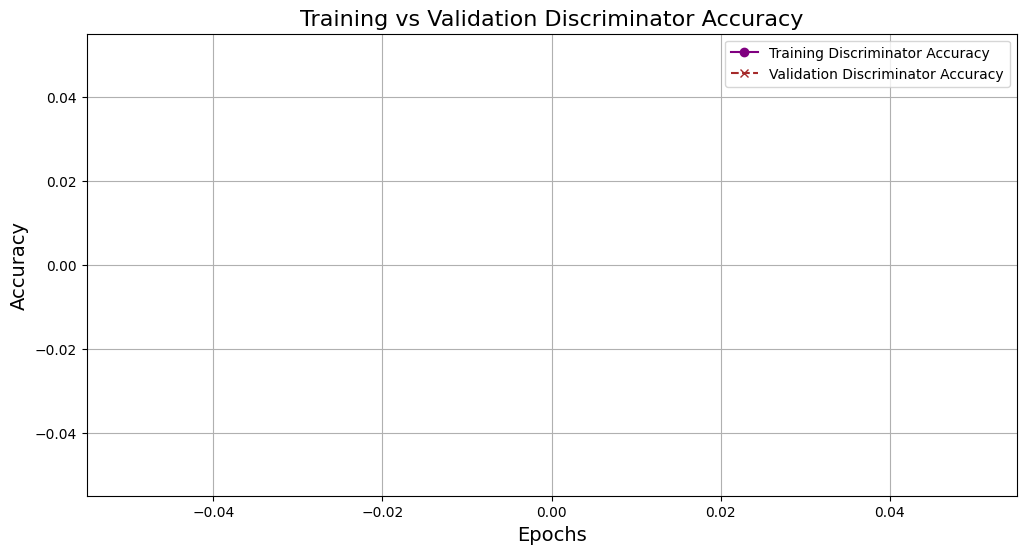

In [19]:
import matplotlib.pyplot as plt

# Plot Autoencoder Losses
plt.figure(figsize=(12, 6))
plt.plot(autoencoder_losses_epoch, label='Training Autoencoder Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_autoencoder_losses_epoch, label='Validation Autoencoder Loss', color='red', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training vs Validation Autoencoder Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.savefig('autoencoder_losses.png')  # Save the plot as an image
plt.show()

# Plot Discriminator Losses
plt.figure(figsize=(12, 6))
plt.plot(discriminator_losses_epoch, label='Training Discriminator Loss', color='green', linestyle='-', marker='o')
plt.plot(val_discriminator_losses_epoch, label='Validation Discriminator Loss', color='orange', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training vs Validation Discriminator Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.savefig('discriminator_losses.png')  # Save the plot as an image
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(12, 6))
plt.plot(discriminator_acc_epoch, label='Training Discriminator Accuracy', color='purple', linestyle='-', marker='o')
plt.plot(val_discriminator_acc_epoch, label='Validation Discriminator Accuracy', color='brown', linestyle='--', marker='x')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training vs Validation Discriminator Accuracy', fontsize=16)
plt.legend()
plt.grid(True)
plt.savefig('discriminator_accuracy.png')  # Save the plot as an image
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt

# Define constants
latent_dim = 100  # Latent dimension for generator input
output_dir = "gan_model"  # Directory to save models
os.makedirs(output_dir, exist_ok=True)

# Initialize loss lists before training
generator_losses = []
discriminator_losses = []

# Define the generator
def build_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 512, activation="relu", input_dim=latent_dim),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.Conv2DTranspose(3, kernel_size=3, activation="tanh", padding="same")
    ])
    return model

# Define the discriminator
def build_discriminator(img_shape):
    model = keras.Sequential([
        layers.Flatten(input_shape=img_shape),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# Build models
generator = build_generator(latent_dim)
discriminator = build_discriminator((64, 64, 3))

# Compile the discriminator
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    metrics=["accuracy"]
)

# Compile the GAN model
discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = models.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5))

# Training function
def train_gan(generator, discriminator, gan, train_data, latent_dim, epochs=17, batch_size=8):
    for epoch in range(epochs):
        epoch_d_loss = []  # To track the discriminator loss for each batch in this epoch
        epoch_g_loss = []  # To track the generator loss for each batch in this epoch

        for _ in range(len(train_data) // batch_size):
            # Generate random noise and fake images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator.predict(noise)

            # Select a random batch of real images
            idx = np.random.randint(0, train_data.shape[0], batch_size)
            real_images = train_data[idx]

            # Create labels for real (1) and fake (0) images
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])  # Assuming loss is the first item

            # Train the generator via the GAN model
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)

            # Append losses for this batch
            epoch_d_loss.append(d_loss)
            epoch_g_loss.append(g_loss[0])

        # Average losses for the epoch
        discriminator_losses.append(np.mean(epoch_d_loss))
        generator_losses.append(np.mean(epoch_g_loss))

        # Save model weights after each epoch
        if (epoch + 1) % 5 == 0:  # Save models every 5 epochs
            generator.save(f"{output_dir}/generator_epoch_{epoch + 1}.h5")
            discriminator.save(f"{output_dir}/discriminator_epoch_{epoch + 1}.h5")
        print(f"Epoch {epoch + 1}/{epochs} completed.")

# Load or create training data (example with random data)
train_data = np.random.random((1000, 64, 64, 3)) * 2 - 1  # Example dataset with random noise

# Train the GAN
train_gan(generator, discriminator, gan, train_data, latent_dim, epochs=17, batch_size=8)

# Plot the losses for the generator and discriminator after training
plt.figure(figsize=(12, 6))

# Plot generator loss
plt.plot(generator_losses, label="Generator Loss", color="blue")

# Plot discriminator loss
plt.plot(discriminator_losses, label="Discriminator Loss", color="red")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Generate random noise to create fake images
noise = np.random.normal(0, 1, (5, latent_dim))  # Generate 5 images
fake_images = generator.predict(noise)

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow((fake_images[i] + 1) / 2)  # Rescale images from [-1, 1] to [0, 1]
    plt.axis('off')
plt.show()


In [ ]:
# Select a random batch of real images and fake images
idx = np.random.randint(0, train_data.shape[0], 10)
real_images = train_data[idx]
fake_images = generator.predict(np.random.normal(0, 1, (10, latent_dim)))

# Evaluate the discriminator on real and fake images
real_preds = discriminator.predict(real_images)
fake_preds = discriminator.predict(fake_images)

print("Real images discriminator predictions:", real_preds)
print("Fake images discriminator predictions:", fake_preds)


In [ ]:
generator.save(f"{output_dir}/generator_final.h5")
discriminator.save(f"{output_dir}/discriminator_final.h5")
print("Final models saved.")


In [ ]:
# Assuming you have lists for losses (this would need to be updated during training)
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses Over Epochs")
plt.legend()
plt.show()
